# Quantum Error Mitigation using Qiskit 1.0

In [15]:
import numpy as np
import jax
import mthree
import scipy.optimize as opt
from qiskit import QuantumCircuit, pulse, transpile, schedule
from qiskit.primitives import BackendSampler
from qiskit.pulse.library import Gaussian
from qiskit.pulse.library import Drag
from qiskit_dynamics import DynamicsBackend, Solver
from qiskit_dynamics.array import Array
from qiskit.providers.basic_provider import BasicProvider
from qiskit_ibm_runtime.fake_provider import FakeProvider, FakeValencia, FakeSherbrooke, FakeKolkata, FakeAthens
from qiskit_ibm_provider import IBMProvider
from qiskit.circuit.library import XGate, SXGate, RZGate, CXGate, TwoLocal
from qiskit.circuit import Gate, Parameter
import qiskit_ibm_provider.jupyter
from qiskit.visualization import plot_histogram, plot_distribution
from qiskit.primitives import (
    Sampler, # V1
    StatevectorSampler, #V2
    Estimator, #V1
    StatevectorEstimator, #V2
)
from qiskit_experiments.library import LocalReadoutError, CorrelatedReadoutError
from qiskit.result.mitigation.utils import (
    expval_with_stddev,
    str2diag,
    counts_probability_vector
)

## Readout Error Mitigation

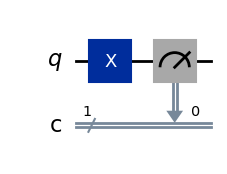

In [5]:
circ = QuantumCircuit(1, 1)
circ.x(0)
circ.measure(0, 0)
circ.draw('mpl')

The counts are: {'1': 1024}


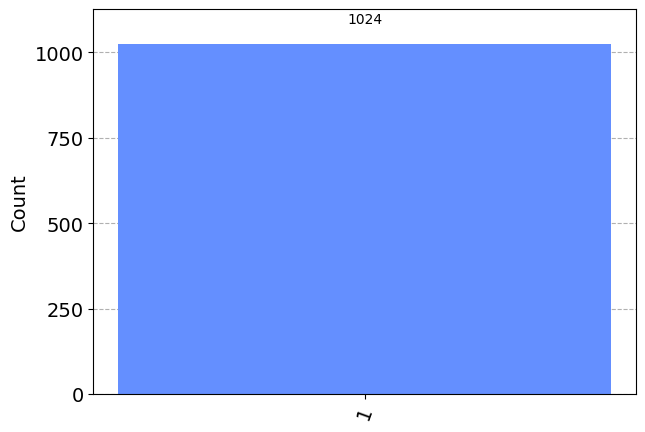

In [8]:
# Execute the quantum circuit using State Vector Sampler V2

sampler_v2 = StatevectorSampler()
result = sampler_v2.run([circ], shots=1024).result()
data_pub = result[0].data
#print(data_pub)
# Get counts for the classical register "c"
noiseless_counts = data_pub.c.get_counts()
print(f"The counts are: {noiseless_counts}")

plot_histogram(noiseless_counts)

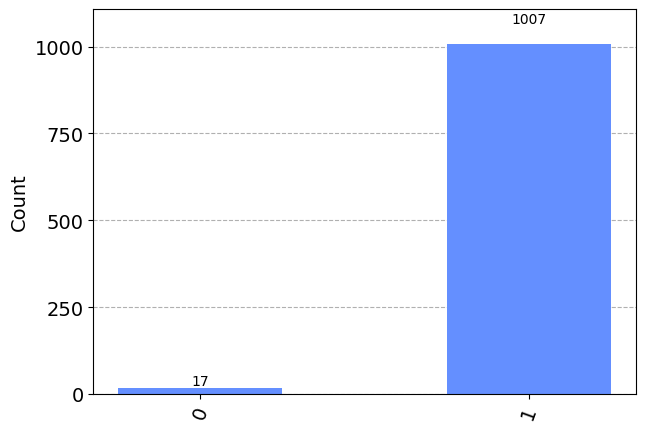

In [7]:
# Executing on Fake Quantum Hardware Provider

backend2 = FakeSherbrooke()
transpiled_circ = transpile(circ, backend2)
# Run the transpiled circuit using the simulated fake backend
job_fake = backend2.run(transpiled_circ, shots=1024)
noisy_counts = job_fake.result().get_counts()
plot_histogram(noisy_counts)

In [12]:
qubits = [0]
exp = LocalReadoutError(qubits)
for c in exp.circuits():
    print(c)

         ░ ┌─┐
     q: ─░─┤M├
         ░ └╥┘
meas: 1/════╩═
            0 
        ┌───┐ ░ ┌─┐
     q: ┤ X ├─░─┤M├
        └───┘ ░ └╥┘
meas: 1/═════════╩═
                 0 


In [13]:
exp.analysis.set_options(plot=True)
result = exp.run(backend2)
mitigator = result.analysis_results("Local Readout Mitigator").value

Adding a job from a backend (AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['measure', 'x', 'ecr', 'sx']>)) that is different than the current backend (<qiskit_ibm_runtime.fake_provider.backends.sherbrooke.fake_sherbrooke.FakeSherbrooke object at 0x000002B0CF877D00>). The new backend will be used, but service is not changed if one already exists.


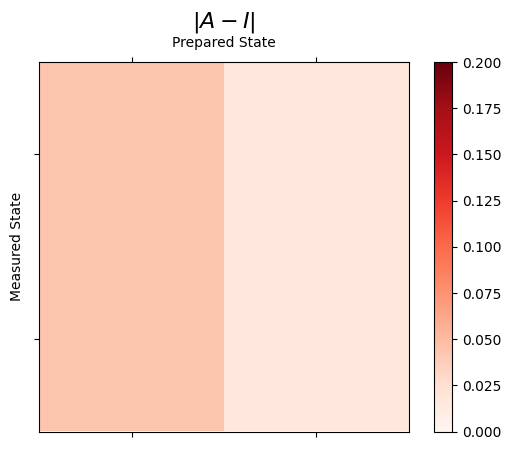

In [14]:
result.figure(0)

In [15]:
shots = 1024
unmitigated_probs = {label: count / shots for label, count in noisy_counts.items()}
mitigated_quasi_probs = mitigator.quasi_probabilities(noisy_counts)
mitigated_stddev = mitigated_quasi_probs._stddev_upper_bound
mitigated_probs = (mitigated_quasi_probs.nearest_probability_distribution().binary_probabilities())

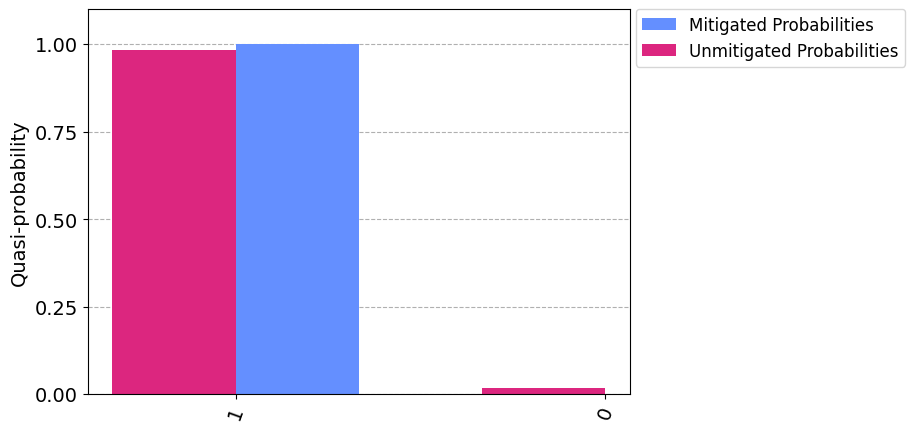

In [18]:
legend = ['Mitigated Probabilities', 'Unmitigated Probabilities']
plot_distribution([mitigated_probs, unmitigated_probs], legend=legend, sort="value_desc", bar_labels=False)

## MThree for Error Mitigation

### Simple Circuit Example

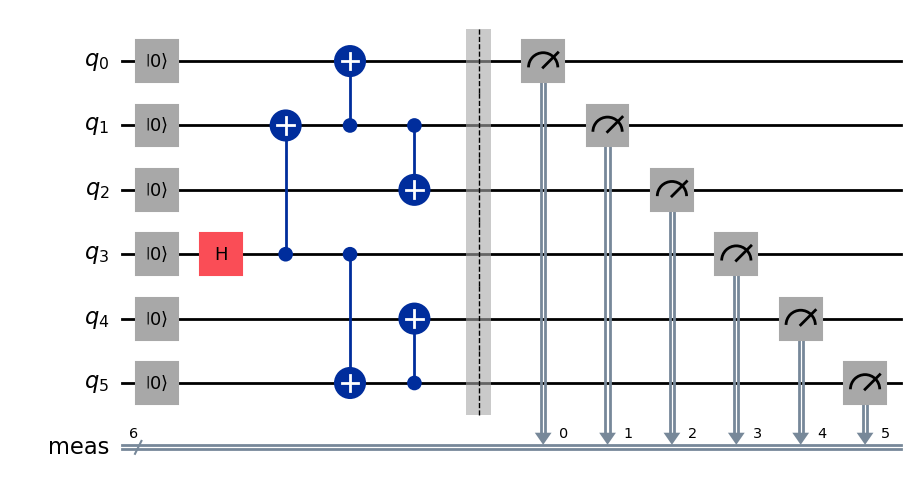

In [2]:
qc = QuantumCircuit(6)
qc.reset(range(6))
qc.h(3)
qc.cx(3,1)
qc.cx(3,5)
qc.cx(1,0)
qc.cx(5,4)
qc.cx(1,2)
qc.measure_all()
qc.draw('mpl')

In [3]:
backend = FakeKolkata()
mit = mthree.M3Mitigation(backend)
mit.cals_from_system(range(6))

In [4]:
trans_qc = transpile(qc, backend)
raw_counts = backend.run(trans_qc).result().get_counts()

In [5]:
quasis = mit.apply_correction(raw_counts, range(6))
print('Expectation value:',quasis.expval())

Expectation value: 1.0106560566352158


### VQE Error Mitigation Example

In [7]:
H_op = [(0.39793742484318045, 'YZ'), (-0.39793742484318045, 'ZI'),
       (-0.01128010425623538, 'ZZ'), (0.18093119978423156, 'XX')]

ansatz = TwoLocal(2, rotation_blocks='ry', entanglement_blocks='cx')

In [8]:
coeffs = np.array([item[0] for item in H_op], dtype=float)
op_strings = [item[1] for item in H_op]

In [9]:
def opstr_to_meas_circ(op_str):
    num_qubits = len(op_str[0])
    circs = []
    for op in op_str:
        qc = QuantumCircuit(num_qubits)
        for idx, item in enumerate(op):
            if item == 'X':
                qc.h(num_qubits-idx-1)
            elif item == 'Y':
                qc.sdg(num_qubits-idx-1)
                qc.h(num_qubits-idx-1)
        circs.append(qc)
    return circs

In [10]:
meas_circs = opstr_to_meas_circ(op_strings)

In [11]:
full_circs = [ansatz.compose(meas_circs[kk]).measure_all(inplace=False) for kk in range(len(meas_circs))]

In [12]:
meas_strings = [string.replace('X', 'Z').replace('Y', 'Z') for string in op_strings]
meas_strings

['ZZ', 'ZI', 'ZZ', 'ZZ']

In [16]:
backend = FakeAthens()
trans_circs = transpile(full_circs, backend)

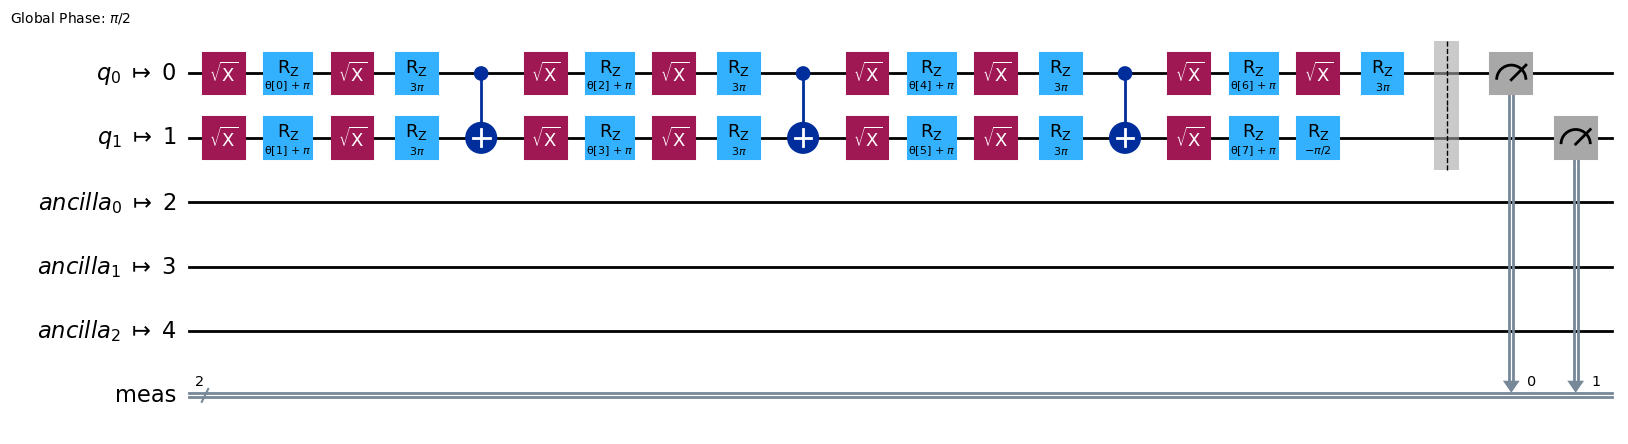

In [17]:
trans_circs[0].draw('mpl')

In [18]:
num_params = ansatz.num_parameters
params = np.array([1.22253725, 0.39053752, 0.21462153, 5.48308027,
                   2.06984514, 3.65227416, 4.01911194, 0.35749589])
params += 0.05*(np.random.random(params.shape[0])-0.5)

In [19]:
mit = mthree.M3Mitigation(backend)
mit.cals_from_system([0,1])

In [22]:
def vqe_func(params, *args):
    # Attach parameters to the transpiled circuit variables
    bound_circs = [circ.assign_parameters(params) for circ in trans_circs]
    # Submit the job and get the resultant counts back
    counts = backend.run(bound_circs, shots=4096).result().get_counts()
    # Apply mitigation to get quasi-probabilities
    quasis = mit.apply_correction(counts, [0,1])
    # Evaluate the coefficients times each expectation value obtained from quasi-probabilities and sum.
    energy = np.sum(coeffs*quasis.expval(meas_strings))
    return energy

In [23]:
res = opt.minimize(vqe_func, params, method = 'COBYLA')

In [24]:
print(res.fun)
print(np.mod(res.x, 2*np.pi))

-0.43276573777861704
[1.23487659 0.38619121 0.18958865 5.4930516  2.04959943 3.67294063
 4.03413889 0.34299616]
